In [1]:
import streamlit as st
import datetime as date
import yfinance as yf
import pandas_datareader as data
import numpy as np

In [2]:
from plotly import graph_objs as go

In [3]:
start = "2015-01-01"
today = date.datetime.today().strftime("%Y-%m-%d")
# print(today)

2022-05-20


In [4]:
df = data.DataReader('INFY' , 'yahoo',start,today)
# df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-12-31,7.9875,7.850,7.9300,7.865,5498800.0,6.539760
2015-01-02,8.0600,7.915,8.0575,7.975,13401600.0,6.631224
2015-01-05,7.9350,7.835,7.9175,7.875,10076400.0,6.548075
2015-01-06,7.9250,7.695,7.8475,7.820,13290800.0,6.502342
2015-01-07,8.0475,7.845,7.8500,7.985,23202800.0,6.639541


In [5]:
df1 = df.reset_index()['Close']
# df1.head()

0    7.865
1    7.975
2    7.875
3    7.820
4    7.985
Name: Close, dtype: float64

In [6]:
#LSTM are sensitive to the scale of the data. So we apply MinMax scaler

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
scaler =MinMaxScaler(feature_range=(0,1))
df2 = scaler.fit_transform(np.array(df1).reshape(-1,1)) # Reshape so that you get a 1 D array instead of 2D

In [9]:
# df2.shape

(1860, 1)

In [10]:
# df2

array([[0.05514041],
       [0.06080906],
       [0.05565575],
       ...,
       [0.66039681],
       [0.61762433],
       [0.60989429]])

In [11]:
#Splitting the data into training and testing

In [12]:
training_size = int(len(df2)*0.65) #70% of the data is used for training
test_size = len(df2) - training_size
train_data,test_data = df2[0:training_size,:],df2[training_size:len(df2),:1]

In [13]:
# train_data

array([[0.05514041],
       [0.06080906],
       [0.05565575],
       ...,
       [0.19608349],
       [0.19556815],
       [0.19453746]])

In [14]:
def create_dataset(dataset,time_step=1):
    dataX,dataY=[],[]
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX), np.array(dataY)

In [95]:
time_step=150
X_train,y_train =create_dataset(train_data,time_step)
X_test,y_test= create_dataset(test_data,time_step)

In [96]:
# print(X_train)

In [97]:
# print(X_train.shape),print(y_train.shape)

In [98]:
#Reshape input which is required in LSTM which is convert to 3D

In [99]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
                       

In [100]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [101]:
model =Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(150,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [102]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 150, 50)           10400     
                                                                 
 lstm_7 (LSTM)               (None, 150, 50)           20200     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [129]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=64,verbose=1)

Epoch 1/20
17/17 [==============================] - 3s 185ms/step - loss: 7.1840e-05 - val_loss: 4.8544e-04
Epoch 2/20
17/17 [==============================] - 3s 193ms/step - loss: 6.2877e-05 - val_loss: 7.8872e-04
Epoch 3/20
17/17 [==============================] - 3s 186ms/step - loss: 6.1756e-05 - val_loss: 0.0015
Epoch 4/20
17/17 [==============================] - 3s 205ms/step - loss: 5.7799e-05 - val_loss: 9.7650e-04
Epoch 5/20
17/17 [==============================] - 3s 180ms/step - loss: 5.9564e-05 - val_loss: 0.0016
Epoch 6/20
17/17 [==============================] - 3s 180ms/step - loss: 5.6419e-05 - val_loss: 0.0017
Epoch 7/20
17/17 [==============================] - 3s 181ms/step - loss: 5.7180e-05 - val_loss: 0.0010
Epoch 8/20
17/17 [==============================] - 3s 181ms/step - loss: 6.1612e-05 - val_loss: 9.7052e-04
Epoch 9/20
17/17 [==============================] - 3s 181ms/step - loss: 5.7047e-05 - val_loss: 0.0013
Epoch 10/20
17/17 [=============================

In [130]:
train_predict=model.predict(X_train)
test_predict= model.predict(X_test)

In [131]:
train_predict=scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [132]:
#Calculate the RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
# math.sqrt(mean_squared_error(y_train,train_predict))

In [133]:
# math.sqrt(mean_squared_error(y_test,test_predict))

In [134]:
#Plotting the actual data, train and test data

In [152]:
look_back=150
trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :]= train_predict

In [157]:
import pandas as pd

In [167]:
train_plot=pd.DataFrame(trainPredictPlot)
train_plot.rename(columns={0:'Values'},inplace=True)
train_plot.head()

,Values
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


In [136]:
testPredictPlot = np.empty_like(df2)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df2)-1, :] = test_predict

In [168]:
test_plot=pd.DataFrame(testPredictPlot)
test_plot.rename(columns={0:'Values'},inplace=True)
test_plot.tail()

,Values
1855,19.438030
1856,19.185369
1857,18.533203
1858,19.749195
1859,NaN


In [137]:
import matplotlib.pyplot as plt

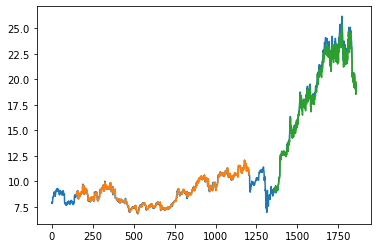

In [138]:
plt.plot(scaler.inverse_transform(df2))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [139]:
#Now predict 30 days

In [140]:
# len(test_data)

In [141]:
x_input = test_data[len(test_data)-150:].reshape(1,-1)
x_input.shape

(1, 150)

In [142]:
temp_input = list(x_input)
temp_input=temp_input[0].tolist()

In [179]:
temp_input

[0.8546765523119216,
 0.8752898742250813,
 0.8979643710629913,
 0.8933263834616908,
 0.8562225809428897,
 0.8356093573213336,
 0.8314867125970223,
 0.8191187784240886,
 0.8119040764378415,
 0.8124194193148307,
 0.7979902119255434,
 0.8077814317135302,
 0.8175727497931208,
 0.8201493658864639,
 0.8201493658864639,
 0.8242721089023787,
 0.8577686095738578,
 0.8505539075876104,
 0.8330326429363869,
 0.8454006754009241,
 0.8711672295007701,
 0.8675598293618446,
 0.8881731512750043,
 0.8732285027171239,
 0.8685905151158234,
 0.8654985561454908,
 0.8232414231483999,
 0.829425341089065,
 0.8149961336997776,
 0.7938675672012322,
 0.8155114765767669,
 0.8134501050688095,
 0.8062355013741657,
 0.8577686095738578,
 0.8289099982120757,
 0.7964441832945753,
 0.8381859734146769,
 0.8577686095738578,
 0.8479772914942673,
 0.8448853325239348,
 0.8149961336997776,
 0.829425341089065,
 0.8484926343712565,
 0.8922957959993155,
 0.8886884941519936,
 0.8706518866237808,
 0.8979643710629913,
 0.913939705374

In [181]:
# lst_output=[]
# n_steps = 150
# i=0
# while(i<30):
#     if (len(temp_input)>150):
#         x_input = np.array(temp_input[1:])
#         print("{} day input {}".format(i,x_input))
#         x_input=x_input.reshape(1,-1)
#         x_input=x_input.reshape((1,n_steps,1))
#         yhat = model.predict(x_input, verbose=0)
#         print("{} day ouput {}".format(i,yhat))
#         lst_output.extend(yhat.tolist())
#         i=i+1
#     else:
#         x_input = x_input.reshape((1,n_steps,1))
#         yhat = model.predict(x_input,verbose=0)
#         print(yhat[0])
#         temp_input.extend(yhat[0].tolist())
#         print(len(temp_input))
#         lst_output.extend(yhat.tolist())
#         i=i+1

0 day input [0.87528987 0.89796437 0.89332638 0.85622258 0.83560936 0.83148671
 0.81911878 0.81190408 0.81241942 0.79799021 0.80778143 0.81757275
 0.82014937 0.82014937 0.82427211 0.85776861 0.85055391 0.83303264
 0.84540068 0.87116723 0.86755983 0.88817315 0.8732285  0.86859052
 0.86549856 0.82324142 0.82942534 0.81499613 0.79386757 0.81551148
 0.81345011 0.8062355  0.85776861 0.82891    0.79644418 0.83818597
 0.85776861 0.84797729 0.84488533 0.81499613 0.82942534 0.84849263
 0.8922958  0.88868849 0.87065189 0.89796437 0.91393971 0.92424627
 0.95516615 0.95362012 0.95774277 0.9592888  0.95413547 0.95155885
 0.9438289  0.90208702 0.8922958  0.89693378 0.92630764 0.93919092
 0.97681006 0.96908012 1.         0.96444213 0.91084765 0.87013654
 0.85622258 0.83200206 0.80829677 0.80365879 0.77376959 0.81757275
 0.86446787 0.86189125 0.87477453 0.82272608 0.82942534 0.80778143
 0.82942534 0.85622258 0.83200206 0.79747487 0.79335222 0.82942534
 0.82684872 0.80572016 0.8098428  0.83767063 0.820

5 day ouput [[0.5952817]]
6 day input [0.87528987 0.89796437 0.89332638 0.85622258 0.83560936 0.83148671
 0.81911878 0.81190408 0.81241942 0.79799021 0.80778143 0.81757275
 0.82014937 0.82014937 0.82427211 0.85776861 0.85055391 0.83303264
 0.84540068 0.87116723 0.86755983 0.88817315 0.8732285  0.86859052
 0.86549856 0.82324142 0.82942534 0.81499613 0.79386757 0.81551148
 0.81345011 0.8062355  0.85776861 0.82891    0.79644418 0.83818597
 0.85776861 0.84797729 0.84488533 0.81499613 0.82942534 0.84849263
 0.8922958  0.88868849 0.87065189 0.89796437 0.91393971 0.92424627
 0.95516615 0.95362012 0.95774277 0.9592888  0.95413547 0.95155885
 0.9438289  0.90208702 0.8922958  0.89693378 0.92630764 0.93919092
 0.97681006 0.96908012 1.         0.96444213 0.91084765 0.87013654
 0.85622258 0.83200206 0.80829677 0.80365879 0.77376959 0.81757275
 0.86446787 0.86189125 0.87477453 0.82272608 0.82942534 0.80778143
 0.82942534 0.85622258 0.83200206 0.79747487 0.79335222 0.82942534
 0.82684872 0.80572016 0

11 day ouput [[0.5952817]]
12 day input [0.87528987 0.89796437 0.89332638 0.85622258 0.83560936 0.83148671
 0.81911878 0.81190408 0.81241942 0.79799021 0.80778143 0.81757275
 0.82014937 0.82014937 0.82427211 0.85776861 0.85055391 0.83303264
 0.84540068 0.87116723 0.86755983 0.88817315 0.8732285  0.86859052
 0.86549856 0.82324142 0.82942534 0.81499613 0.79386757 0.81551148
 0.81345011 0.8062355  0.85776861 0.82891    0.79644418 0.83818597
 0.85776861 0.84797729 0.84488533 0.81499613 0.82942534 0.84849263
 0.8922958  0.88868849 0.87065189 0.89796437 0.91393971 0.92424627
 0.95516615 0.95362012 0.95774277 0.9592888  0.95413547 0.95155885
 0.9438289  0.90208702 0.8922958  0.89693378 0.92630764 0.93919092
 0.97681006 0.96908012 1.         0.96444213 0.91084765 0.87013654
 0.85622258 0.83200206 0.80829677 0.80365879 0.77376959 0.81757275
 0.86446787 0.86189125 0.87477453 0.82272608 0.82942534 0.80778143
 0.82942534 0.85622258 0.83200206 0.79747487 0.79335222 0.82942534
 0.82684872 0.80572016

17 day ouput [[0.5952817]]
18 day input [0.87528987 0.89796437 0.89332638 0.85622258 0.83560936 0.83148671
 0.81911878 0.81190408 0.81241942 0.79799021 0.80778143 0.81757275
 0.82014937 0.82014937 0.82427211 0.85776861 0.85055391 0.83303264
 0.84540068 0.87116723 0.86755983 0.88817315 0.8732285  0.86859052
 0.86549856 0.82324142 0.82942534 0.81499613 0.79386757 0.81551148
 0.81345011 0.8062355  0.85776861 0.82891    0.79644418 0.83818597
 0.85776861 0.84797729 0.84488533 0.81499613 0.82942534 0.84849263
 0.8922958  0.88868849 0.87065189 0.89796437 0.91393971 0.92424627
 0.95516615 0.95362012 0.95774277 0.9592888  0.95413547 0.95155885
 0.9438289  0.90208702 0.8922958  0.89693378 0.92630764 0.93919092
 0.97681006 0.96908012 1.         0.96444213 0.91084765 0.87013654
 0.85622258 0.83200206 0.80829677 0.80365879 0.77376959 0.81757275
 0.86446787 0.86189125 0.87477453 0.82272608 0.82942534 0.80778143
 0.82942534 0.85622258 0.83200206 0.79747487 0.79335222 0.82942534
 0.82684872 0.80572016

24 day input [0.87528987 0.89796437 0.89332638 0.85622258 0.83560936 0.83148671
 0.81911878 0.81190408 0.81241942 0.79799021 0.80778143 0.81757275
 0.82014937 0.82014937 0.82427211 0.85776861 0.85055391 0.83303264
 0.84540068 0.87116723 0.86755983 0.88817315 0.8732285  0.86859052
 0.86549856 0.82324142 0.82942534 0.81499613 0.79386757 0.81551148
 0.81345011 0.8062355  0.85776861 0.82891    0.79644418 0.83818597
 0.85776861 0.84797729 0.84488533 0.81499613 0.82942534 0.84849263
 0.8922958  0.88868849 0.87065189 0.89796437 0.91393971 0.92424627
 0.95516615 0.95362012 0.95774277 0.9592888  0.95413547 0.95155885
 0.9438289  0.90208702 0.8922958  0.89693378 0.92630764 0.93919092
 0.97681006 0.96908012 1.         0.96444213 0.91084765 0.87013654
 0.85622258 0.83200206 0.80829677 0.80365879 0.77376959 0.81757275
 0.86446787 0.86189125 0.87477453 0.82272608 0.82942534 0.80778143
 0.82942534 0.85622258 0.83200206 0.79747487 0.79335222 0.82942534
 0.82684872 0.80572016 0.8098428  0.83767063 0.82

29 day ouput [[0.5952817]]


In [182]:
from numpy import array

lst_output=[]
n_steps=150
i=0
while(i<30):
    
    if(len(temp_input)>150):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.87528987 0.89796437 0.89332638 0.85622258 0.83560936 0.83148671
 0.81911878 0.81190408 0.81241942 0.79799021 0.80778143 0.81757275
 0.82014937 0.82014937 0.82427211 0.85776861 0.85055391 0.83303264
 0.84540068 0.87116723 0.86755983 0.88817315 0.8732285  0.86859052
 0.86549856 0.82324142 0.82942534 0.81499613 0.79386757 0.81551148
 0.81345011 0.8062355  0.85776861 0.82891    0.79644418 0.83818597
 0.85776861 0.84797729 0.84488533 0.81499613 0.82942534 0.84849263
 0.8922958  0.88868849 0.87065189 0.89796437 0.91393971 0.92424627
 0.95516615 0.95362012 0.95774277 0.9592888  0.95413547 0.95155885
 0.9438289  0.90208702 0.8922958  0.89693378 0.92630764 0.93919092
 0.97681006 0.96908012 1.         0.96444213 0.91084765 0.87013654
 0.85622258 0.83200206 0.80829677 0.80365879 0.77376959 0.81757275
 0.86446787 0.86189125 0.87477453 0.82272608 0.82942534 0.80778143
 0.82942534 0.85622258 0.83200206 0.79747487 0.79335222 0.82942534
 0.82684872 0.80572016 0.8098428  0.83767063 0.820

5 day output [[0.55882317]]
6 day input [0.81911878 0.81190408 0.81241942 0.79799021 0.80778143 0.81757275
 0.82014937 0.82014937 0.82427211 0.85776861 0.85055391 0.83303264
 0.84540068 0.87116723 0.86755983 0.88817315 0.8732285  0.86859052
 0.86549856 0.82324142 0.82942534 0.81499613 0.79386757 0.81551148
 0.81345011 0.8062355  0.85776861 0.82891    0.79644418 0.83818597
 0.85776861 0.84797729 0.84488533 0.81499613 0.82942534 0.84849263
 0.8922958  0.88868849 0.87065189 0.89796437 0.91393971 0.92424627
 0.95516615 0.95362012 0.95774277 0.9592888  0.95413547 0.95155885
 0.9438289  0.90208702 0.8922958  0.89693378 0.92630764 0.93919092
 0.97681006 0.96908012 1.         0.96444213 0.91084765 0.87013654
 0.85622258 0.83200206 0.80829677 0.80365879 0.77376959 0.81757275
 0.86446787 0.86189125 0.87477453 0.82272608 0.82942534 0.80778143
 0.82942534 0.85622258 0.83200206 0.79747487 0.79335222 0.82942534
 0.82684872 0.80572016 0.8098428  0.83767063 0.82066471 0.79592884
 0.82684872 0.80726609

11 day output [[0.5233681]]
12 day input [0.82014937 0.82014937 0.82427211 0.85776861 0.85055391 0.83303264
 0.84540068 0.87116723 0.86755983 0.88817315 0.8732285  0.86859052
 0.86549856 0.82324142 0.82942534 0.81499613 0.79386757 0.81551148
 0.81345011 0.8062355  0.85776861 0.82891    0.79644418 0.83818597
 0.85776861 0.84797729 0.84488533 0.81499613 0.82942534 0.84849263
 0.8922958  0.88868849 0.87065189 0.89796437 0.91393971 0.92424627
 0.95516615 0.95362012 0.95774277 0.9592888  0.95413547 0.95155885
 0.9438289  0.90208702 0.8922958  0.89693378 0.92630764 0.93919092
 0.97681006 0.96908012 1.         0.96444213 0.91084765 0.87013654
 0.85622258 0.83200206 0.80829677 0.80365879 0.77376959 0.81757275
 0.86446787 0.86189125 0.87477453 0.82272608 0.82942534 0.80778143
 0.82942534 0.85622258 0.83200206 0.79747487 0.79335222 0.82942534
 0.82684872 0.80572016 0.8098428  0.83767063 0.82066471 0.79592884
 0.82684872 0.80726609 0.7918062  0.81396545 0.81035815 0.80726609
 0.81345011 0.8520999

17 day output [[0.49558836]]
18 day input [0.84540068 0.87116723 0.86755983 0.88817315 0.8732285  0.86859052
 0.86549856 0.82324142 0.82942534 0.81499613 0.79386757 0.81551148
 0.81345011 0.8062355  0.85776861 0.82891    0.79644418 0.83818597
 0.85776861 0.84797729 0.84488533 0.81499613 0.82942534 0.84849263
 0.8922958  0.88868849 0.87065189 0.89796437 0.91393971 0.92424627
 0.95516615 0.95362012 0.95774277 0.9592888  0.95413547 0.95155885
 0.9438289  0.90208702 0.8922958  0.89693378 0.92630764 0.93919092
 0.97681006 0.96908012 1.         0.96444213 0.91084765 0.87013654
 0.85622258 0.83200206 0.80829677 0.80365879 0.77376959 0.81757275
 0.86446787 0.86189125 0.87477453 0.82272608 0.82942534 0.80778143
 0.82942534 0.85622258 0.83200206 0.79747487 0.79335222 0.82942534
 0.82684872 0.80572016 0.8098428  0.83767063 0.82066471 0.79592884
 0.82684872 0.80726609 0.7918062  0.81396545 0.81035815 0.80726609
 0.81345011 0.85209994 0.88147379 0.87838183 0.88714247 0.92218499
 0.89641844 0.943828

23 day output [[0.47257558]]
24 day input [0.86549856 0.82324142 0.82942534 0.81499613 0.79386757 0.81551148
 0.81345011 0.8062355  0.85776861 0.82891    0.79644418 0.83818597
 0.85776861 0.84797729 0.84488533 0.81499613 0.82942534 0.84849263
 0.8922958  0.88868849 0.87065189 0.89796437 0.91393971 0.92424627
 0.95516615 0.95362012 0.95774277 0.9592888  0.95413547 0.95155885
 0.9438289  0.90208702 0.8922958  0.89693378 0.92630764 0.93919092
 0.97681006 0.96908012 1.         0.96444213 0.91084765 0.87013654
 0.85622258 0.83200206 0.80829677 0.80365879 0.77376959 0.81757275
 0.86446787 0.86189125 0.87477453 0.82272608 0.82942534 0.80778143
 0.82942534 0.85622258 0.83200206 0.79747487 0.79335222 0.82942534
 0.82684872 0.80572016 0.8098428  0.83767063 0.82066471 0.79592884
 0.82684872 0.80726609 0.7918062  0.81396545 0.81035815 0.80726609
 0.81345011 0.85209994 0.88147379 0.87838183 0.88714247 0.92218499
 0.89641844 0.9438289  0.91187833 0.9402216  0.89744903 0.92733833
 0.90260236 0.921154

29 day output [[0.45283034]]
[[0.595281720161438], [0.5876906514167786], [0.5802046656608582], [0.5729206204414368], [0.5657803416252136], [0.5588231682777405], [0.5521209836006165], [0.5457362532615662], [0.5396955013275146], [0.5339840650558472], [0.5285590291023254], [0.5233681201934814], [0.518365740776062], [0.5135213732719421], [0.508821964263916], [0.5042654275894165], [0.4998542368412018], [0.49558836221694946], [0.4914633333683014], [0.48746949434280396], [0.483594685792923], [0.47982701659202576], [0.4761563241481781], [0.4725755751132965], [0.46908038854599], [0.4656691551208496], [0.4623402953147888], [0.4590924084186554], [0.4559233486652374], [0.45283034443855286]]


In [178]:
lst_output

[[0.6048001050949097],
 [0.595281720161438],
 [0.595281720161438],
 [0.595281720161438],
 [0.595281720161438],
 [0.595281720161438],
 [0.595281720161438],
 [0.595281720161438],
 [0.595281720161438],
 [0.595281720161438],
 [0.595281720161438],
 [0.595281720161438],
 [0.595281720161438],
 [0.595281720161438],
 [0.595281720161438],
 [0.595281720161438],
 [0.595281720161438],
 [0.595281720161438],
 [0.595281720161438],
 [0.595281720161438],
 [0.595281720161438],
 [0.595281720161438],
 [0.595281720161438],
 [0.595281720161438],
 [0.595281720161438],
 [0.595281720161438],
 [0.595281720161438],
 [0.595281720161438],
 [0.595281720161438],
 [0.595281720161438]]

In [177]:
print(scaler.inverse_transform(lst_output))

[[18.53114653]
 [18.34644226]
 [18.34644226]
 [18.34644226]
 [18.34644226]
 [18.34644226]
 [18.34644226]
 [18.34644226]
 [18.34644226]
 [18.34644226]
 [18.34644226]
 [18.34644226]
 [18.34644226]
 [18.34644226]
 [18.34644226]
 [18.34644226]
 [18.34644226]
 [18.34644226]
 [18.34644226]
 [18.34644226]
 [18.34644226]
 [18.34644226]
 [18.34644226]
 [18.34644226]
 [18.34644226]
 [18.34644226]
 [18.34644226]
 [18.34644226]
 [18.34644226]
 [18.34644226]]


In [183]:
day_new=np.arange(1,151)
day_pred =np.arange(151,181)

In [184]:
day_new

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150])

In [185]:
len(df2)

1860

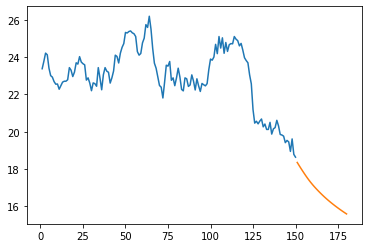

In [186]:
plt.plot(day_new,scaler.inverse_transform(df2[len(df2)-150:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

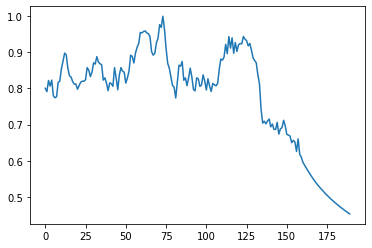

In [187]:
df3 = df2.tolist()
df3.extend(lst_output)
plt.plot(df3[1700:])